In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
import requests
from lmfit import minimize, Parameters, Parameter, report_fit
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton

style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def SEIR_model(y, t, lamda, lam2, delta, mu):  
    S, E, I, R = y
    N = S + E + I + R
    ds_dt = - lamda * S * I / N  - lam2 * S * E / N            
    de_dt = lamda * S * I / N + lam2 * S * E / N - delta * E  
    di_dt = delta * E - mu * I                  
    dr_dt = mu * I
    return np.array([ds_dt,de_dt,di_dt,dr_dt])

In [3]:
def SEIR_solver(t, initial_conditions, params):
    initE, initI, initR, initN = initial_conditions
    lamda, lam2, delta, mu = params['lamda'].value, params['lam2'].value, params['delta'].value, params['mu'].value
    initS = initN - (initE + initI + initR)
    res = odeint(SEIR_model, [initS, initE, initI, initR], t, args=(lamda, lam2, delta, mu))
    return res

In [4]:
data = pd.read_csv('Data_India.csv')
India = data[data['Country']=='India']
India = India.loc[70:]
India.index = range(0,len(India)) # 将index改成从1开始
India.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,total_confirmed,total_deaths,total_recoverd
0,2021/3/12,IN,India,SEARO,23285,11308846,117,158306,11308846,158306,10973260
1,2021/3/13,IN,India,SEARO,24882,11333728,140,158446,11333728,158446,10989897
2,2021/3/14,IN,India,SEARO,25320,11359048,161,158607,11359048,158607,11007352
3,2021/3/15,IN,India,SEARO,26291,11385339,118,158725,11385339,158725,11027543
4,2021/3/16,IN,India,SEARO,24492,11409831,131,158856,11409831,158856,11045284


In [5]:
df_covid_history = India.sort_values(by='Date_reported')
df_covid_history['infected'] = India['total_confirmed']
df_covid_history['total_recovered_or_dead'] = India['total_recoverd'] + India['total_deaths']

In [6]:
initN = 13.24e8
initE = 100000
initI = 11308846
initR = 158306 + 10973260

lamda = 1.0
lam2 = 0.25
delta = 0.05  
mu = 0.1
#beta = R0 * gamma
days = 200

params = Parameters()
params.add('lamda', value=lamda, min=0, max=10)
params.add('lam2', value=lam2, min=0, max=10)
params.add('delta', value=delta, min=0, max=10)
params.add('mu', value=mu, min=0, max=10)

In [7]:
def main(initE, initI, initR, initN, lamda, lam2, delta, mu, days, param_fitting):
    initial_conditions = [initE, initI, initR, initN]
    params['lamda'].value, params['lam2'].value,params['delta'].value, params['mu'].value = [lamda, lam2, delta, mu]
    tspan = np.arange(0, days, 1)
    sol = SEIR_solver(tspan, initial_conditions, params)
    S, E, I, R = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]
    
    # Create traces
    fig = go.Figure()
    if not param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=S, mode='lines+markers', name='Susceptible'))
        fig.add_trace(go.Scatter(x=tspan, y=E, mode='lines+markers', name='Exposed'))
    fig.add_trace(go.Scatter(x=tspan, y=I, mode='lines+markers', name='Infected'))
    fig.add_trace(go.Scatter(x=tspan, y=R, mode='lines+markers',name='Recovered'))
    if param_fitting:
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.infected, mode='lines+markers',\
                             name='Infections Observed', line = dict(dash='dash')))
        fig.add_trace(go.Scatter(x=tspan, y=df_covid_history.total_recovered_or_dead, mode='lines+markers',\
                             name='Recovered/Deceased Observed', line = dict(dash='dash')))
    
    if days <= 30:
        step = 1
    elif days <= 90:
        step = 7
    else:
        step = 30
    
    # Edit the layout
    fig.update_layout(title='Simulation of SEIR Model',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=900, height=600
                     )
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, days + 1, step))
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.write_image("images/seir_simulation.png")
    fig.show()

In [8]:
interact(main, initE=IntSlider(min=0, max=100000, step=1, value=initE, description='initE', style=style, \
                               layout=slider_layout),
               initI=IntSlider(min=0, max=100000, step=10, value=initI, description='initI', style=style, \
                               layout=slider_layout),
               initR=IntSlider(min=0, max=100000, step=10, value=initR, description='initR', style=style, \
                               layout=slider_layout),
               initN=IntSlider(min=0, max=1380000000, step=1000, value=initN, description='initN', style=style, \
                               layout=slider_layout),
               lamda=FloatSlider(min=0, max=4, step=0.01, value=lamda, description='Infection rate', style=style, \
                                layout=slider_layout),
               lam2=FloatSlider(min=0, max=4, step=0.01, value=lam2, description='Infection rate2', style=style, \
                                layout=slider_layout),
               delta=FloatSlider(min=0, max=4, step=0.01, value=delta, description='Incubation rate', style=style, \
                                 layout=slider_layout),
               mu=FloatSlider(min=0, max=4, step=0.01, value=mu, description='Recovery rate', style=style, \
                                 layout=slider_layout),
               days=IntSlider(min=0, max=600, step=7, value=days, description='Days', style=style, \
                              layout=slider_layout),
               param_fitting=ToggleButton(value=False, description='Fitting Mode', disabled=False, button_style='', \
             tooltip='Click to show fewer plots', icon='check-circle')
        );

interactive(children=(IntSlider(value=100000, description='initE', layout=Layout(width='99%'), max=100000, sty…

In [9]:
def error(params, initial_conditions, tspan, data):
    sol = SEIR_solver(tspan, initial_conditions, params)
    return (sol[:, 2:4] - data).ravel()

In [10]:
initial_conditions = [initE, initI, initR, initN]
lamda = 0.2
lam2 = 0.1
delta = 0.05  
mu = 0.1
params['lamda'].value = lamda
params['lam2'].value = lam2
params['delta'].value = delta
params['mu'].value = mu
days = 82
tspan = np.arange(0, days, 1)
data = df_covid_history.loc[0:(days-1), ['infected', 'total_recovered_or_dead']].values

In [11]:
params

name,value,initial value,min,max,vary
lamda,0.20000000,1.0,0.00000000,10.0000000,True
lam2,0.10000000,0.25,0.00000000,10.0000000,True
delta,0.05000000,0.05,0.00000000,10.0000000,True
mu,0.10000000,0.1,0.00000000,10.0000000,True


In [12]:
result = minimize(error, params, args=(initial_conditions, tspan, data), method='leastsq')

In [13]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
lamda,3.85375450,4.72785397,(122.68%),0.2,0.00000000,10.0000000,True
lam2,0.06793573,0.17636618,(259.61%),0.1,0.00000000,10.0000000,True
delta,3.3623e-04,3.2641e-05,(9.71%),0.05,0.00000000,10.0000000,True
mu,0.00879012,4.6420e-04,(5.28%),0.1,0.00000000,10.0000000,True


In [14]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 164
    # variables        = 4
    chi-square         = 1.2837e+15
    reduced chi-square = 8.0229e+12
    Akaike info crit   = 4876.93561
    Bayesian info crit = 4889.33508
[[Variables]]
    lamda:  3.85375450 +/- 4.72785397 (122.68%) (init = 0.2)
    lam2:   0.06793573 +/- 0.17636618 (259.61%) (init = 0.1)
    delta:  3.3623e-04 +/- 3.2641e-05 (9.71%) (init = 0.05)
    mu:     0.00879012 +/- 4.6420e-04 (5.28%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(lamda, lam2)  = -0.973
    C(lam2, delta)  = -0.687
    C(lamda, delta) =  0.516
    C(delta, mu)    =  0.286
    C(lamda, mu)    = -0.124


In [15]:
final = data + result.residual.reshape(data.shape)
fig = go.Figure()
fig.add_trace(go.Scatter(x=tspan, y=data[:, 0], mode='markers', name='Observed Infections', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=data[:, 1], mode='markers', name='Observed Recovered/Deceased', line = dict(dash='dot')))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 0], mode='lines+markers', name='Fitted Infections'))
fig.add_trace(go.Scatter(x=tspan, y=final[:, 1], mode='lines+markers', name='Fitted Recovered/Deceased'))
fig.update_layout(title='Observed vs Fitted',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=1000, height=600
                     )

In [16]:
observed_IR = df_covid_history.loc[:, ['infected', 'total_recovered_or_dead']].values
print(observed_IR.shape)

(82, 2)


In [17]:
tspan_fit_pred = np.arange(0, observed_IR.shape[0], 1)
params['lamda'].value = result.params['lamda'].value
params['lam2'].value = result.params['lam2'].value
params['delta'].value = result.params['delta'].value
params['mu'].value = result.params['mu'].value
fitted_predicted = SEIR_solver(tspan_fit_pred, initial_conditions, params)
fitted_predicted_IR = fitted_predicted[:, 2:4]
print(fitted_predicted_IR.shape)

(82, 2)


In [18]:
print("Fitted MAE")
print('Infected: ', np.mean(np.abs(fitted_predicted_IR[:days, 0] - observed_IR[:days, 0])))
print('Recovered/Deceased: ', np.mean(np.abs(fitted_predicted_IR[:days, 1] - observed_IR[:days, 1])))

print("\nFitted RMSE")
print('Infected: ', np.sqrt(np.mean((fitted_predicted_IR[:days, 0] - observed_IR[:days, 0])**2)))
print('Recovered/Deceased: ', np.sqrt(np.mean((fitted_predicted_IR[:days, 1] - observed_IR[:days, 1])**2)))

Fitted MAE
Infected:  2045735.1349423912
Recovered/Deceased:  2246266.287284419

Fitted RMSE
Infected:  2803343.629244566
Recovered/Deceased:  2792088.052617486


In [19]:
interact(main, initE=IntSlider(min=0, max=100000, step=1, value=initE, description='initE', style=style, \
                               layout=slider_layout),
               initI=IntSlider(min=0, max=100000, step=10, value=initI, description='initI', style=style, \
                               layout=slider_layout),
               initR=IntSlider(min=0, max=100000, step=10, value=initR, description='initR', style=style, \
                               layout=slider_layout),
               initN=IntSlider(min=0, max=1380000000, step=1000, value=initN, description='initN', style=style, \
                               layout=slider_layout),
               lamda=FloatSlider(min=0, max=4, step=0.01, value=lamda, description='Infection rate', style=style, \
                                layout=slider_layout),
               lam2=FloatSlider(min=0, max=4, step=0.01, value=lam2, description='Infection rate2', style=style, \
                                layout=slider_layout),
               delta=FloatSlider(min=0, max=4, step=0.01, value=delta, description='Incubation rate', style=style, \
                                 layout=slider_layout),
               mu=FloatSlider(min=0, max=4, step=0.01, value=mu, description='Recovery rate', style=style, \
                                 layout=slider_layout),
               days=IntSlider(min=0, max=600, step=7, value=days, description='Days', style=style, \
                              layout=slider_layout),
               param_fitting=ToggleButton(value=False, description='Fitting Mode', disabled=False, button_style='', \
             tooltip='Click to show fewer plots', icon='check-circle')
        );

interactive(children=(IntSlider(value=100000, description='initE', layout=Layout(width='99%'), max=100000, sty…

In [20]:
data = pd.read_csv('Data_India.csv')
India = data[data['Country'] == 'India']
data1 = data[['Date_reported','total_confirmed','total_deaths','total_recoverd']].loc[70:]
data1.index = range(1,len(data1) + 1) # 将index改成从1开始
data1.head()

,Date_reported,total_confirmed,total_deaths,total_recoverd
1,2021/3/12,11308846,158306,10973260
2,2021/3/13,11333728,158446,10989897
3,2021/3/14,11359048,158607,11007352
4,2021/3/15,11385339,158725,11027543
5,2021/3/16,11409831,158856,11045284


In [21]:
N = 13.24e8
infectious_real = data1['total_confirmed']
recovered_real = data1['total_recoverd'] + data1['total_deaths']

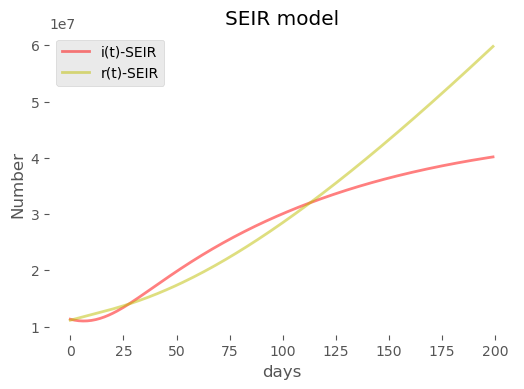

In [22]:
def SEIR2(y, t, lamda, lam2, delta, mu):  
    S, E, I, R = y
    N = S + E + I + R
    ds_dt = - lamda * S * I / N - lam2 * S * E / N            
    de_dt = lamda * S * I / N + lam2 * S * E / N - delta * E  
    di_dt = delta * E - mu * I                       
    dr_dt = mu * I  
    return np.array([ds_dt,de_dt,di_dt,dr_dt])


N = 13.24e8 
# Daily exposure rate, the average number of susceptible persons effectively exposed to the disease per day
lamda = 3.839
lam2 = 0.069
delta = 3.3617e-04
mu = 0.0088

#Number of exposures during the infectious period
sigma = lamda / mu  

fsig = 1-1/sigma

#Predicted date length
tEnd = 200

t = np.arange(0.0, tEnd, 1)  # (start,stop,step)

#Initial value of the proportion of people with the disease
i0 = 11308846 
e0 = 100000
r0 = (158306 + 10973260)
s0 = N - i0 - e0 - r0
Y0 = (s0, e0, i0, r0)  


SEIR2 = odeint(SEIR2, Y0, t, args=(lamda,lam2,delta,mu))  # SEIR2 model

fig, ax = plt.subplots(facecolor='w', dpi=100)
for index, color, label_name in zip(range(2,4), ['r','y'], ['i(t)-SEIR', 'r(t)-SEIR']):
    ax.plot(t, SEIR2[:, index], color, alpha=0.5, lw=2, label=label_name)

#print("λ={}\t λ2={}\t δ={}\t (1-1/sig)={}".format(lamda,lam2,sigma,fsig))
plt.title("SEIR model")
ax.set_xlabel('days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)


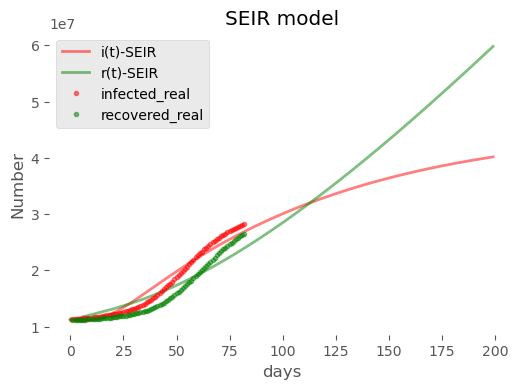

In [23]:
fig, ax = plt.subplots(facecolor='w', dpi=100)
for index, color, label_name in zip(range(2,4), ['r','g'], ['i(t)-SEIR', 'r(t)-SEIR']):
    ax.plot(t, SEIR2[:, index], color, alpha=0.5, lw=2, label=label_name)
    
plt.plot(infectious_real, 'r.', alpha=0.5, lw=2, label='infected_real')
plt.plot(recovered_real, 'g.', alpha=0.5, lw=2, label='recovered_real')
    
#print("λ={}\t λ2={}\t δ={}\t (1-1/sig)={}".format(lamda,lam2,sigma,fsig))
plt.title("SEIR model")
ax.set_xlabel('days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)

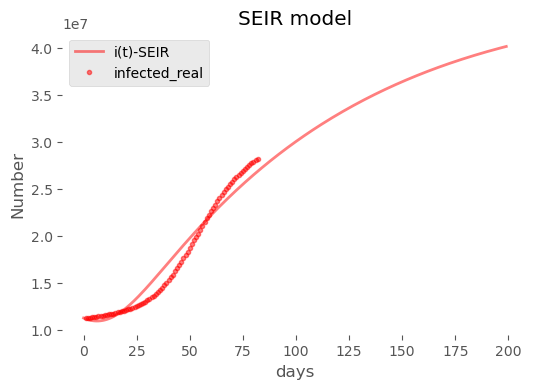

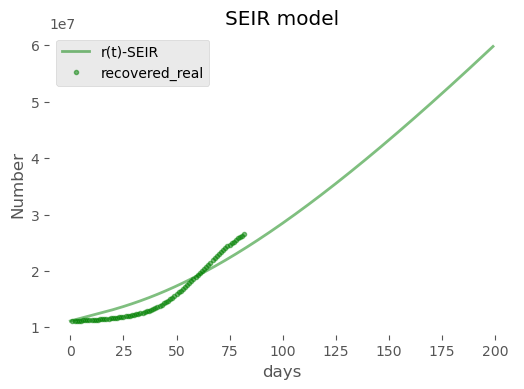

In [24]:
fig, ax = plt.subplots(facecolor='w', dpi=100)
for index, color, label_name in zip(range(2,3), ['r'], ['i(t)-SEIR']):
    ax.plot(t, SEIR2[:, index], color, alpha=0.5, lw=2, label=label_name)
    
plt.plot(infectious_real, 'r.', alpha=0.5, lw=2, label='infected_real')
#plt.plot(recovered_real, 'g.', alpha=0.5, lw=2, label='recovered_real')
    
#print("λ={}\t λ2={}\t δ={}\t (1-1/sig)={}".format(lamda,lam2,sigma,fsig))
plt.title("SEIR model")
ax.set_xlabel('days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)
fig, ax = plt.subplots(facecolor='w', dpi=100)

for index, color, label_name in zip(range(3,4), ['g'], ['r(t)-SEIR']):
    ax.plot(t, SEIR2[:, index], color, alpha=0.5, lw=2, label=label_name)
    
#plt.plot(infectious_real, 'r.', alpha=0.5, lw=2, label='infected_real')
plt.plot(recovered_real, 'g.', alpha=0.5, lw=2, label='recovered_real')
    
#print("λ={}\t λ2={}\t δ={}\t (1-1/sig)={}".format(lamda,lam2,sigma,fsig))
plt.title("SEIR model")
ax.set_xlabel('days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)